In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

from tqdm import trange, tqdm

In [2]:
input_video_file = "../inputs/savadkuh_240p.mp4"
output_video_file = "../outputs/compressed_savadkuh_240p_no_limit.mp4"

In [3]:
def read_frames(input_video_file):
    cap = cv2.VideoCapture(input_video_file)

    fps = cap.get(cv2.CAP_PROP_FPS)
    frames = []
    while True:
        ret, frame = cap.read()
        
        if not ret:
            break
        
        # Write the frame to the new video file
        frames.append(frame)
    
    return frames, fps

In [4]:
frames, fps = read_frames(input_video_file)
print("fps:", fps)
print("number of frames:", len(frames))

fps: 29.969308601793138
number of frames: 897


(240, 426, 3)


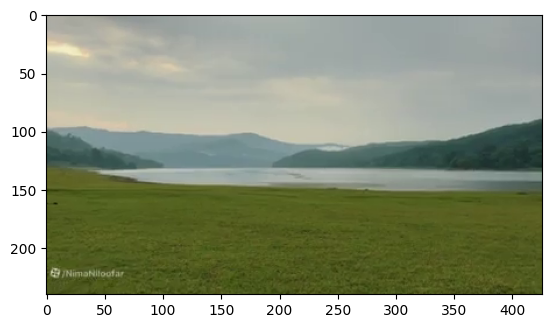

In [5]:
f0 = frames[0][:,:,[2, 1, 0]]
print(f0.shape)
plt.imshow(f0)
plt.show()

In [6]:
def compute_histogram_diff(image1, image2):
    hist1_r, _ = np.histogram(image1[:, :, 0], bins=256, range=(0, 256))
    hist1_g, _ = np.histogram(image1[:, :, 1], bins=256, range=(0, 256))
    hist1_b, _ = np.histogram(image1[:, :, 2], bins=256, range=(0, 256))
    
    hist2_r, _ = np.histogram(image2[:, :, 0], bins=256, range=(0, 256))
    hist2_g, _ = np.histogram(image2[:, :, 1], bins=256, range=(0, 256))
    hist2_b, _ = np.histogram(image2[:, :, 2], bins=256, range=(0, 256))

    hist1_r = hist1_r / hist1_r.sum()
    hist1_g = hist1_g / hist1_g.sum()
    hist1_b = hist1_b / hist1_b.sum()

    hist2_r = hist2_r / hist2_r.sum()
    hist2_g = hist2_g / hist2_g.sum()
    hist2_b = hist2_b / hist2_b.sum()

    return np.abs(hist1_r - hist2_r).sum() + np.abs(hist1_g - hist2_g).sum() + np.abs(hist1_b - hist2_b).sum()

compute_histogram_diff(frames[0], frames[1])

np.float64(0.1457550860719875)

In [7]:
def cluster_frames(frames, thresh_old):
    frame_hist_diff = []
    divided_frames = []
    divided_frames.append([frames[0]])
    for i in trange(1, len(frames)):
        d = compute_histogram_diff(divided_frames[-1][0], frames[i])
        if d >= thresh_old:
            divided_frames.append([])
            d = compute_histogram_diff(frames[i], frames[i])
        divided_frames[-1].append(frames[i])
        frame_hist_diff.append(d)

    return divided_frames, frame_hist_diff


divided_frames, frame_hist_diff = cluster_frames(frames, 0.5)

100%|██████████| 896/896 [00:06<00:00, 132.11it/s]


number of source frames: 21


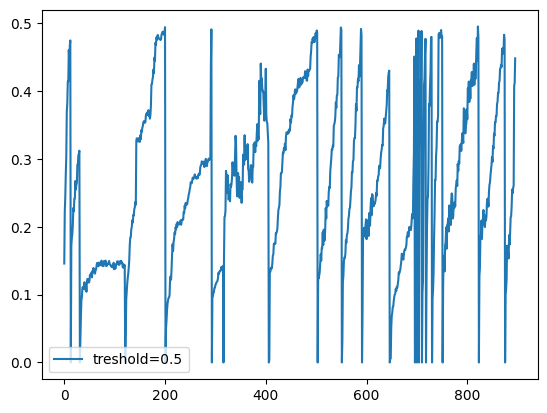

In [8]:
print("number of source frames:", len(divided_frames))
plt.plot(frame_hist_diff, label="treshold=0.5")
plt.legend()
plt.show()

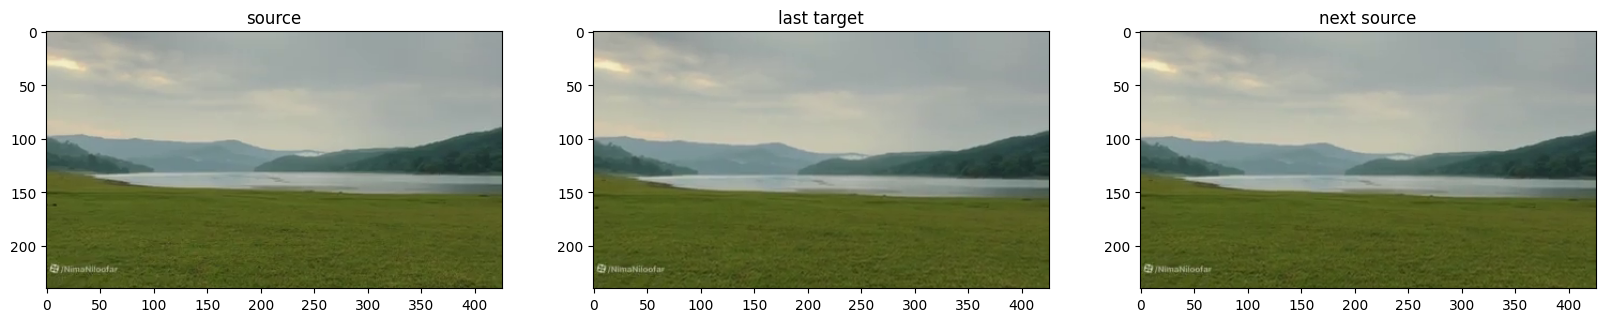

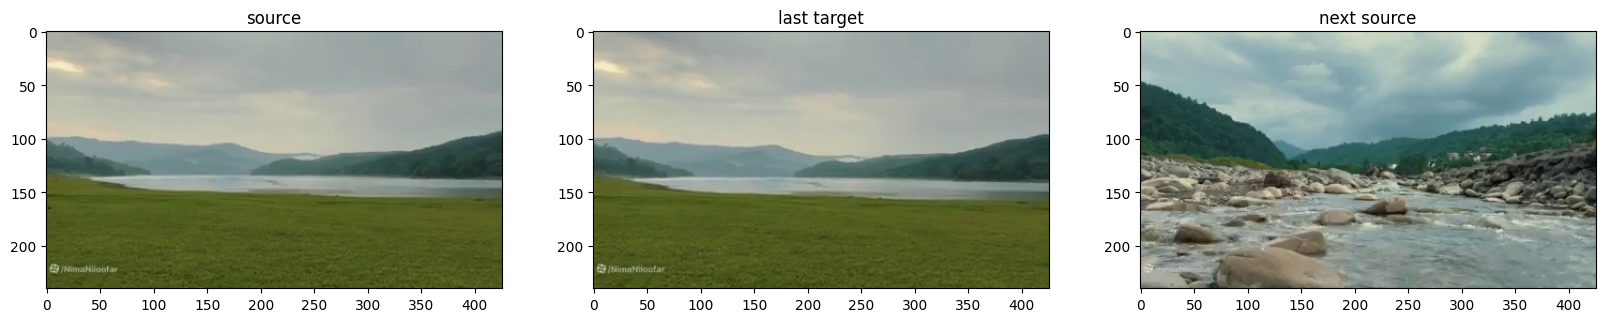

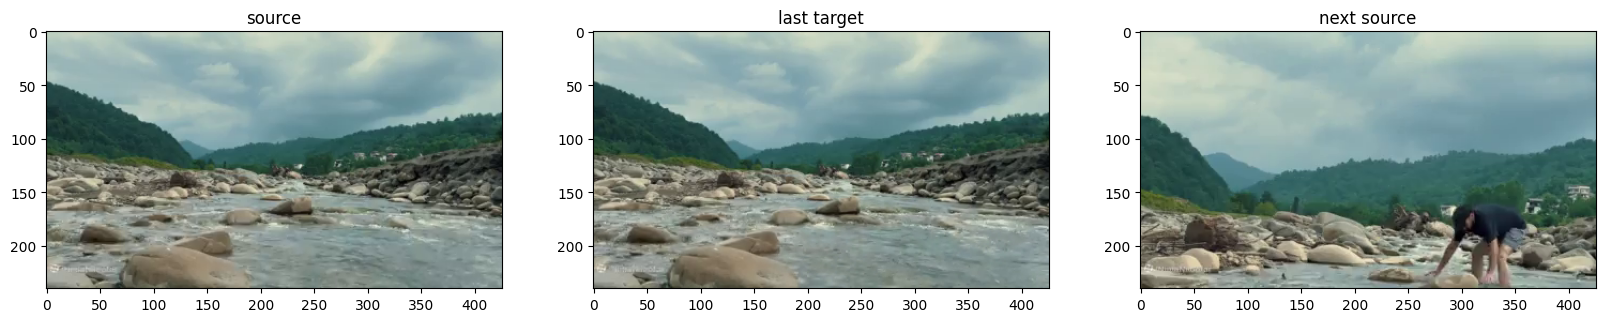

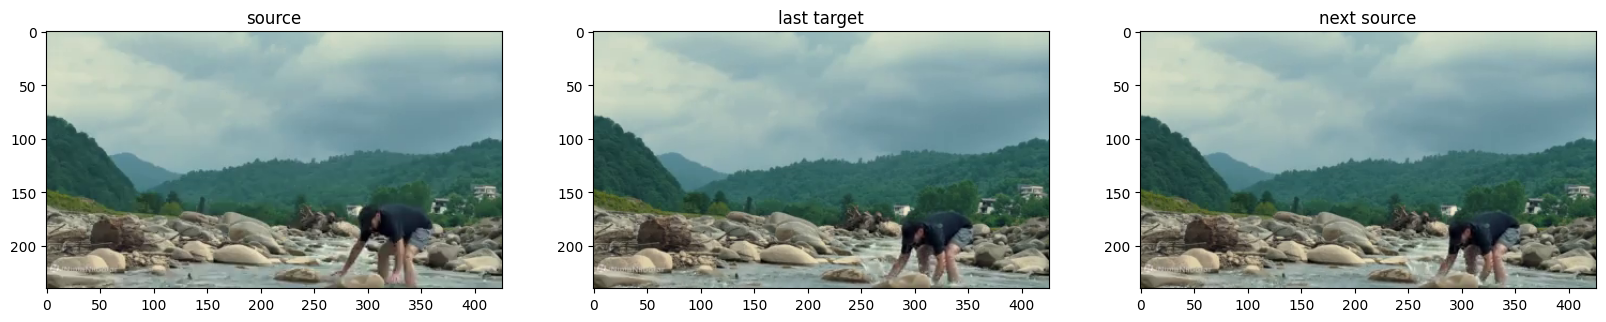

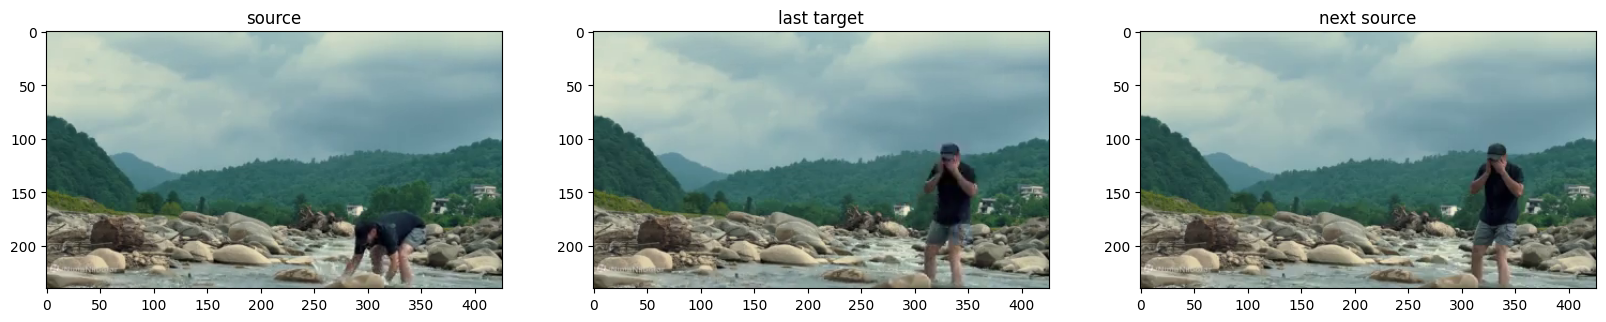

In [9]:
for i in range(min(len(divided_frames)-1, 5)):
    plt.figure(figsize=(20, 10))

    plt.subplot(1, 3, 1)
    plt.title("source")
    plt.imshow(divided_frames[i][0][:,:,[2, 1, 0]])

    plt.subplot(1, 3, 2)
    plt.title("last target")
    plt.imshow(divided_frames[i][-1][:,:,[2, 1, 0]])

    plt.subplot(1, 3, 3)
    plt.title("next source")
    plt.imshow(divided_frames[i+1][0][:,:,[2, 1, 0]])
    plt.show()

In [10]:
def get_coords_no_limit(imgSrc, imgTar, block_size = 5):
    B = block_size
    if len(imgTar.shape) == 2:
        rows, cols = imgTar.shape
        ch = 1
    else:
        rows, cols, ch = imgTar.shape
    
    B = 5  # Block size
    r = rows // B
    c = cols // B
            
    cost_matrix = np.empty((r,c,r,c,ch))

    srcAvg = np.empty((r,c,ch))
    tarAvg = np.empty((r,c,ch))

    for i in tqdm(range(r)):
        for j in range(c):
            srcAvg[i,j] = np.average(imgSrc[i*B:i*B+B, j*B:j*B+B], axis=(0,1))
            tarAvg[i,j] = np.average(imgTar[i*B:i*B+B, j*B:j*B+B], axis=(0,1))

    for i in tqdm(range(r)):
            for j in range(c):
                cost_matrix[i,j] = tarAvg[i,j] -  srcAvg

    cost_matrix = np.linalg.norm(cost_matrix, axis=-1)


    temp = cost_matrix.reshape(r, c, r*c).transpose(2,0,1).reshape(r*c, r*c).transpose(1,0)
    return np.argmin(temp - np.min(temp, axis=1).reshape(-1,1), axis=1).reshape(r,c)


def suffle_pixel(imgSrc, imgTar, coords, block_size = 5):
    B = block_size
    if len(imgTar.shape) == 2:
        rows, cols = imgTar.shape
        ch = 1
        final_arr = np.full((rows, cols), 255, dtype=int)
    else:
        rows, cols, ch = imgTar.shape
        final_arr = np.full((rows, cols, ch), 255, dtype=int)
    r = rows // B
    c = cols // B

    for i in range(r):
        for j in range(c):
            temp = coords[i,j]
            i2 = temp // c
            j2 = temp % c
            
            final_arr[i*B:i*B+B, j*B:j*B+B] = imgSrc[i2*B:i2*B+B, j2*B:j2*B+B].copy()
    return final_arr

In [11]:
counter = 0
result_divided_frames = []


for df in divided_frames:
    result_divided_frames.append([df[0]])
    pbar = trange(1, len(df))
    pbar.set_description("%d/%d" % (counter, len(frames)))
    for i in pbar:
        coords = get_coords_no_limit(df[0], df[i])
        final_image_tr = suffle_pixel(df[0], df[i], coords)
        result_divided_frames[-1].append(final_image_tr)
        
        counter += 1
        pbar.set_description("%d/%d" % (counter, len(frames)))

876/897: 100%|██████████| 20/20 [00:20<00:00,  1.04s/it]


In [12]:
result_frames = sum(result_divided_frames, [])

In [13]:
def write_frames(result_frames, output_video_file, fps):
    height, width, _ = result_frames[0].shape

    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # You can change 'XVID' to other codecs like 'MJPG', 'DIVX', etc.
    video_writer = cv2.VideoWriter(output_video_file, fourcc, fps, (width, height))

    for f in tqdm(result_frames):
        video_writer.write(np.array(f, dtype=np.uint8))

    video_writer.release()

write_frames(result_frames, output_video_file, fps)

  0%|          | 0/897 [00:00<?, ?it/s]

100%|██████████| 897/897 [00:01<00:00, 794.02it/s]


In [14]:
pixel_per_frame = f0.size
coords_per_frame = get_coords_no_limit(f0, f0)[0].size

before_bytes = pixel_per_frame * 1 * len(frames)
after_bytes = pixel_per_frame * 1 * len(divided_frames) +\
             coords_per_frame * 4 * len(frames) - len(divided_frames)

print("before: %10d" % before_bytes)
print("after : %10d" % after_bytes)
print("diff  : %10d" % (before_bytes - after_bytes))
print("compression:", (before_bytes - after_bytes) / before_bytes)

100%|██████████| 48/48 [00:00<00:00, 220.19it/s]


before:  275127840
after :    6746079
diff  :  268381761
compression: 0.975480202221629
